# Prerequisites

In [1]:
import os, sys

import numpy as np
import tqdm
import torch

/home/marco/miniconda3/envs/nlp2022-hw2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Important paths for the notebook:

In [2]:
app_root = '../../../../'
test_name = 'test4'
datasets_path = os.path.join(app_root, 'data')
model_dir_path = os.path.join(app_root, 'model', test_name)

datasets_paths = {}
for lang in os.listdir(datasets_path):
    dataset_lang_path = os.path.join(datasets_path, lang)
    if os.path.isdir(dataset_lang_path):
        datasets_paths[lang] = {}
        for d_type in os.listdir(dataset_lang_path):
            d_name = d_type.split('.')[0]
            datasets_paths[lang][d_name] = os.path.join(dataset_lang_path, d_type)

In [3]:
sys.path.append('../../../')

%load_ext autoreload
%autoreload 2

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Setting the seed for reproducibility:

In [4]:
SEED = 28

# random.seed(SEED) # not used
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
global_params = {
    'batch_size': 32,
    'PAD_TOKEN': '<pad>',
    'UNK_TOKEN': '<unk>',
    'transformer_name': "xlm-roberta-base",
}

# Dataset

I will use RoBERTa

In [6]:
from stud.modelsTests.dataset.SRLDataset_transformer import SRLDataset_transformer

In [7]:
dataset_train_en = SRLDataset_transformer(  datasets_paths['EN']['train'], 
                                            tokenizer = global_params['transformer_name'],
                                            baselines_file_path = os.path.join(app_root,'data/baselines.json'))
dataset_train_es = SRLDataset_transformer(  datasets_paths['ES']['train'], 
                                            tokenizer = dataset_train_en.tokenizer,
                                            labels = dataset_train_en.labels)
dataset_train_fr = SRLDataset_transformer(  datasets_paths['FR']['train'], 
                                            tokenizer = dataset_train_en.tokenizer,
                                            labels = dataset_train_en.labels)

In [8]:
SRLDataset_transformer.save_dict(
    os.path.join(model_dir_path, 'labels.npy'), 
    dataset_train_en.labels)

In [9]:
dataset_dev_en = SRLDataset_transformer(datasets_paths['EN']['dev'], 
                                        tokenizer = dataset_train_en.tokenizer,
                                        labels = dataset_train_en.labels)
dataset_dev_es = SRLDataset_transformer(datasets_paths['ES']['dev'], 
                                        tokenizer = dataset_train_en.tokenizer,
                                        labels = dataset_train_en.labels)
dataset_dev_fr = SRLDataset_transformer(datasets_paths['FR']['dev'], 
                                        tokenizer = dataset_train_en.tokenizer,
                                        labels = dataset_train_en.labels)

In [10]:
next(iter(dataset_train_en)).keys()

dict_keys(['dependency_heads', 'dependency_relations', 'lemmas', 'pos_tags', 'predicates', 'roles', 'words', 'predicate_position', 'predicate_label', 'predicate_word'])

In [11]:
global_params.update({ 
    'n_roles_labels': len(dataset_train_en.labels['id_to_roles']),
    'n_predicates_labels': len(dataset_train_en.labels['id_to_predicates'])
})

Saving global variables...

In [12]:
np.save(os.path.join(model_dir_path, 'global_params.npy'), global_params)

# DataLoader

In [13]:
from torch.utils.data import DataLoader

In [14]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
num_workers = 4

In [15]:
dataloader_train_en = DataLoader(
    dataset_train_en,
    batch_size=global_params['batch_size'],
    collate_fn=dataset_train_en.create_collate_fn(),
    num_workers=num_workers,
    shuffle=True,
)

dataloader_train_es = DataLoader(
    dataset_train_es,
    batch_size=global_params['batch_size'],
    collate_fn=dataset_train_es.create_collate_fn(),
    num_workers=num_workers,
    shuffle=True,
)

dataloader_train_fr = DataLoader(
    dataset_train_fr,
    batch_size=global_params['batch_size'],
    collate_fn=dataset_train_fr.create_collate_fn(),
    num_workers=num_workers,
    shuffle=True,
)

In [16]:
dataloader_dev_en = DataLoader(
    dataset_dev_en,
    batch_size=global_params['batch_size'],
    collate_fn=dataset_dev_en.create_collate_fn(),
    num_workers=num_workers,
    shuffle=False,
)

dataloader_dev_es = DataLoader(
    dataset_dev_es,
    batch_size=global_params['batch_size'],
    collate_fn=dataset_dev_es.create_collate_fn(),
    num_workers=num_workers,
    shuffle=False,
)

dataloader_dev_fr = DataLoader(
    dataset_dev_es,
    batch_size=global_params['batch_size'],
    collate_fn=dataset_dev_fr.create_collate_fn(),
    num_workers=num_workers,
    shuffle=False,
)

# Printing model

In [17]:
from stud.modelsTests.utils.print_infos import *

# English

In [18]:
loss_function = torch.nn.CrossEntropyLoss(ignore_index = dataset_train_en.labels['roles_pad_id']) # !

In [19]:
from stud.modelsTests.model_arg_iden_class_part.Model_aic_transformer_simple import ArgIdenClassModel
import torch.optim as optim

final_model = ArgIdenClassModel(
    language = 'EN',
    device = device,
    model_load_weights = False,
    loss_fn = loss_function,
    fine_tune_transformer=True,
    saves_path_folder = test_name,
)

optimizer = optim.SGD(final_model.model.parameters(), lr=0.0016, momentum=0.9)
# optimizer = optim.Adam(final_model.model.parameters(), lr=0.0016)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
history = {}

In [21]:
from stud.modelsTests.utils.Trainer_aic_transformer_simple import Trainer_aic_transformer_simple

trainer = Trainer_aic_transformer_simple()

history = trainer.train(
    final_model, optimizer, dataloader_train_en, dataloader_dev_en,
    epochs=60, device=device,
    save_best=True, 
    min_score=0.8,
    save_path_name=os.path.join(model_dir_path, 'aic_transformer_weights_en.pth'),
    saved_history=history
)

Epoch   0 => avg_loss: 0.226396
# Validation loss => 0.113821 | f1-score: arg_iden = 0.856741 arg_class = 0.562193 #
Epoch   1 => avg_loss: 0.117762
# Validation loss => 0.095326 | f1-score: arg_iden = 0.876635 arg_class = 0.614409 #
Epoch   2 => avg_loss: 0.102664
# Validation loss => 0.086718 | f1-score: arg_iden = 0.887717 arg_class = 0.659367 #
Epoch   3 => avg_loss: 0.092326
# Validation loss => 0.077602 | f1-score: arg_iden = 0.887718 arg_class = 0.691731 #
Epoch   4 => avg_loss: 0.083607
# Validation loss => 0.071977 | f1-score: arg_iden = 0.888136 arg_class = 0.726820 #
Epoch   5 => avg_loss: 0.082467
# Validation loss => 0.115959 | f1-score: arg_iden = 0.786636 arg_class = 0.563544 #
Epoch   6 => avg_loss: 0.084293
# Validation loss => 0.065853 | f1-score: arg_iden = 0.890053 arg_class = 0.756180 #
Epoch   7 => avg_loss: 0.072595
# Validation loss => 0.061227 | f1-score: arg_iden = 0.893732 arg_class = 0.779966 #
Epoch   8 => avg_loss: 0.065514
# Validation loss => 0.058629 | 

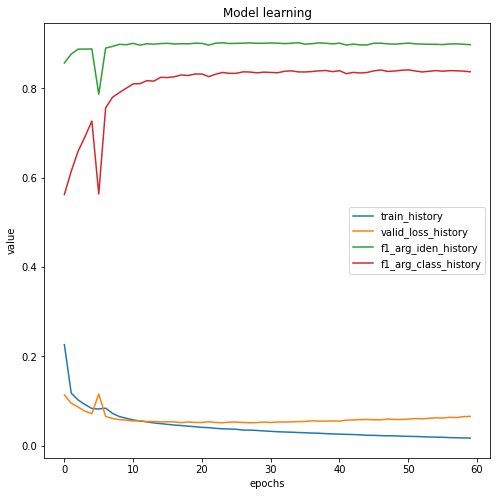

In [22]:
display_history(history)

# Spanish

In [23]:
loss_function = torch.nn.CrossEntropyLoss(ignore_index = dataset_train_en.labels['roles_pad_id']) # !

In [24]:
from stud.modelsTests.model_arg_iden_class_part.Model_aic_transformer_simple import ArgIdenClassModel
import torch.optim as optim

final_model = ArgIdenClassModel(
    language = 'EN',
    device = device,
    model_load_weights = True, # !!!
    loss_fn = loss_function,
    fine_tune_transformer=True,
    saves_path_folder = test_name,
)

optimizer = optim.SGD(final_model.model.parameters(), lr=0.0016, momentum=0.9)
# optimizer = optim.Adam(final_model.model.parameters(), lr=0.0016)

In [25]:
history = {}

In [26]:
from stud.modelsTests.utils.Trainer_aic_transformer_simple import Trainer_aic_transformer_simple

trainer = Trainer_aic_transformer_simple()

history = trainer.train(
    final_model, optimizer, dataloader_train_es, dataloader_dev_es,
    epochs=60, device=device,
    save_best=True, 
    min_score=0.6,
    save_path_name=os.path.join(model_dir_path, 'aic_transformer_weights_es.pth'),
    saved_history=history
)

Epoch   0 => avg_loss: 0.113877
# Validation loss => 0.085242 | f1-score: arg_iden = 0.856129 arg_class = 0.681353 #
----- Best value obtained, saving model -----
Epoch   1 => avg_loss: 0.086681
# Validation loss => 0.078877 | f1-score: arg_iden = 0.859344 arg_class = 0.683394 #
----- Best value obtained, saving model -----
Epoch   2 => avg_loss: 0.079318
# Validation loss => 0.077046 | f1-score: arg_iden = 0.856402 arg_class = 0.679316 #
Epoch   3 => avg_loss: 0.073106
# Validation loss => 0.072948 | f1-score: arg_iden = 0.862146 arg_class = 0.696593 #
----- Best value obtained, saving model -----
Epoch   4 => avg_loss: 0.067324
# Validation loss => 0.073354 | f1-score: arg_iden = 0.859081 arg_class = 0.692484 #
Epoch   5 => avg_loss: 0.063976
# Validation loss => 0.072271 | f1-score: arg_iden = 0.860879 arg_class = 0.698536 #
----- Best value obtained, saving model -----
Epoch   6 => avg_loss: 0.061072
# Validation loss => 0.071678 | f1-score: arg_iden = 0.861091 arg_class = 0.701560

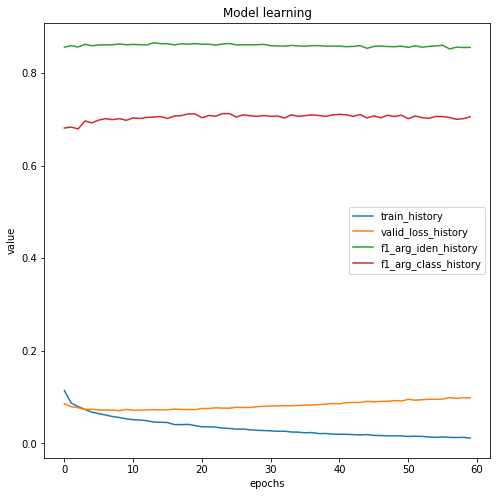

In [27]:
display_history(history)

# French

In [28]:
loss_function = torch.nn.CrossEntropyLoss(ignore_index = dataset_train_en.labels['roles_pad_id']) # !

In [29]:
from stud.modelsTests.model_arg_iden_class_part.Model_aic_transformer_simple import ArgIdenClassModel
import torch.optim as optim

final_model = ArgIdenClassModel(
    language = 'EN',
    device = device,
    model_load_weights = True, # !!!
    loss_fn = loss_function,
    fine_tune_transformer=True,
    saves_path_folder = test_name,
)

optimizer = optim.SGD(final_model.model.parameters(), lr=0.0016, momentum=0.9)
# optimizer = optim.Adam(final_model.model.parameters(), lr=0.0016)

In [30]:
history = {}

In [31]:
from stud.modelsTests.utils.Trainer_aic_transformer_simple import Trainer_aic_transformer_simple

trainer = Trainer_aic_transformer_simple()

history = trainer.train(
    final_model, optimizer, dataloader_train_fr, dataloader_dev_fr,
    epochs=60, device=device,
    save_best=True, 
    min_score=0.6,
    save_path_name=os.path.join(model_dir_path, 'aic_transformer_weights_fr.pth'),
    saved_history=history
)

Epoch   0 => avg_loss: 0.107764
# Validation loss => 0.094001 | f1-score: arg_iden = 0.841540 arg_class = 0.647672 #
----- Best value obtained, saving model -----
Epoch   1 => avg_loss: 0.089630
# Validation loss => 0.086482 | f1-score: arg_iden = 0.844070 arg_class = 0.647184 #
Epoch   2 => avg_loss: 0.079617
# Validation loss => 0.082955 | f1-score: arg_iden = 0.848041 arg_class = 0.655623 #
----- Best value obtained, saving model -----
Epoch   3 => avg_loss: 0.073092
# Validation loss => 0.082860 | f1-score: arg_iden = 0.847504 arg_class = 0.663464 #
----- Best value obtained, saving model -----
Epoch   4 => avg_loss: 0.068149
# Validation loss => 0.081641 | f1-score: arg_iden = 0.849124 arg_class = 0.660266 #
Epoch   5 => avg_loss: 0.064653
# Validation loss => 0.081038 | f1-score: arg_iden = 0.850102 arg_class = 0.655952 #
Epoch   6 => avg_loss: 0.060221
# Validation loss => 0.081272 | f1-score: arg_iden = 0.850415 arg_class = 0.660149 #
Epoch   7 => avg_loss: 0.057223
# Validatio

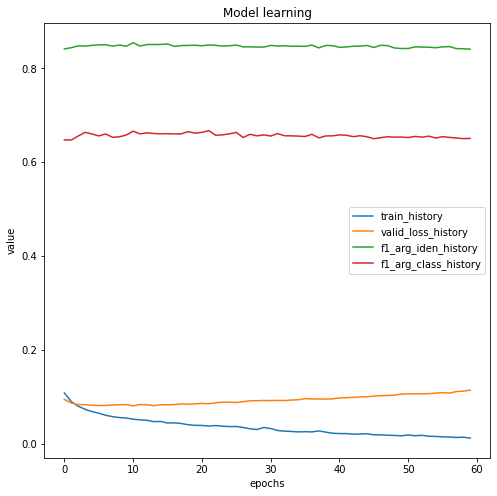

In [32]:
display_history(history)